In [23]:
import pandas as pd
customers = pd.read_csv("../data/external/customers.csv", dtype=str)

customers.head()

,shopUserId,invoiceFirstName,invoiceLastName,invoiceSSN,invoiceZip,invoiceCity,invoiceCountryId,invoiceEmail
0,893240,Marit Bjørnbekk,Tangen,NaN,2422,Nybergsund,160,5278-1758521446.fake@email.com
1,603400,Anna Christine Bergitte,Steen,NaN,4373,Egersund,160,annager.steen@outlook.com
2,791955,Riitta,Laukkanen,170559-196J,52200,Puumala,72,Riitta.laukkanen59@gmail.com
3,442519,Eva Hemstad,Nerberg,NaN,2420,Trysil,160,Evah.nerberg@gmail.com
4,458930,Ragnar,Dahlstedt,194402011656,73692,Kungsör,205,Dahlstedt.lovnas@telia.com


In [24]:

customers.isnull().mean()

shopUserId          0.000000
invoiceFirstName    0.000000
invoiceLastName     0.000000
invoiceSSN          0.361533
invoiceZip          0.000000
invoiceCity         0.000000
invoiceCountryId    0.000000
invoiceEmail        0.000000
dtype: float64

In [25]:
#count all rows
print(len(customers))

84078


In [26]:
# Output a sample of 10 invoiceSSN values and their counts
customers['invoiceSSN'].value_counts(dropna=False).head(10)


invoiceSSN
NaN             30397
temp             2340
195903311149       32
240343-4727        25
21034730684        21
194303291688       18
196112062705       18
030538-006Y        18
250962-1740        17
251153-1085        17
Name: count, dtype: int64

In [27]:
# Display all rows where invoiceSSN is '141052-138Y'
from IPython.display import display
display(customers[customers['invoiceSSN'] == '15044437403'])


,shopUserId,invoiceFirstName,invoiceLastName,invoiceSSN,invoiceZip,invoiceCity,invoiceCountryId,invoiceEmail
15863,812880,Else Marie,Monsen,15044437403,2760,Brandbu,160,4037-1752651873.fake@email.com
23350,758448,Else Marie,Monsen,15044437403,2760,Brandbu,160,3695-1747732356.fake@email.com
26382,742757,Else Marie,Monsen,15044437403,2760,Brandbu,160,8396-1746691669.fake@email.com
27292,739610,Else Marie,Monsen,15044437403,2760,Brandbu,160,1833-1746521204.fake@email.com
43845,630646,Else Marie,Monsen,15044437403,2760,Brandbu,160,3621-1738928969.fake@email.com
58625,458194,Else Marie,Monsen,15044437403,2760,Brandbu,160,2032-1730454239.fake@email.com
63847,410369,Else Marie,Monsen,15044437403,2760,Brandbu,160,2828-1727951617.fake@email.com
75066,333261,Else Marie,Monsen,15044437403,2760,Brandbu,160,6541-1723106503.fake@email.com
77359,308458,Else Marie,Monsen,15044437403,2760,Brandbu,160,5947-1721283346.fake@email.com
78356,296247,Else Marie,Monsen,15044437403,2760,Brandbu,160,6459-1720169085.fake@email.com


Clean shopUserId name lastname zip

In [31]:
import pandas as pd, numpy as np

# Use pandas' dedicated string dtype for better string handling
S = pd.StringDtype()

def clean(s: pd.Series) -> pd.Series:
    """
    Clean a pandas Series of strings by:
    - Converting to pandas StringDtype for consistent string operations
    - Normalizing unicode characters to NFKC form (e.g., full-width to half-width)
    - Replacing all runs of whitespace with a single space
    - Stripping leading/trailing whitespace
    - Masking (setting to <NA>) any value that matches common null/empty patterns
      such as '', 'nan', 'null', 'none', 'n/a', 'n.a.', '-', '.', or '0' (case-insensitive)
    """
    return (
        s.astype(S)
         .str.normalize("NFKC")
         .str.replace(r"\s+", " ", regex=True)
         .str.strip()
         .mask(lambda x: x.str.fullmatch(
             r"(?i)^(|nan|null|none|n/?a|n\.a\.|-|\.|0)$", na=False
         ))
    )

# Read customer and transaction data as strings, disabling default NA parsing
customers = pd.read_csv(
    "../data/external/customers.csv",
    dtype=str,
    keep_default_na=False,
    na_values=[]
)
tx = pd.read_csv(
    "../data/external/transactions.csv",
    dtype=str,
    keep_default_na=False,
    na_values=[]
)

# Clean selected columns in the customers DataFrame
for col in ["shopUserId", "invoiceFirstName", "invoiceLastName", "invoiceZip"]:
    if col in customers:
        customers[col] = clean(customers[col])

# Clean the shopUserId column in the transactions DataFrame
tx["shopUserId"] = clean(tx["shopUserId"])


In [30]:
print(len(tx))

302219


## Normalize city names

In [32]:
import re

COUNTRY_TAIL_RE = re.compile(r'(?:,\s*)?(Denmark|Danmark|Sweden|Sverige|Norway|Norge|Finland|Suomi)\s*$', re.IGNORECASE)
LEADING_POSTAL_RE = re.compile(r'^(?:[A-Z]{1,3}[-\s])?\d{2,3}\s?\d{2,3}\s+|^(?:[A-Z]{1,3}[-\s])?\d{3,6}\s+', re.IGNORECASE)
DIGITS_ANYWHERE_RE = re.compile(r'\d+')

def sentense_case(s):
    if not s:
        return s
    s = s.strip()
    if not s:
        return s
    return s[0].upper() + s[1:].lower() if len(s) > 1 else s.upper()

def normalize_city(x):
    if x is None or pd.isna(x):
        return "Unknown"
    s = str(x)
    s = re.sub(r"\s+", " ", s).strip(" ,")
    if s == "":
        return "Unknown"
    s = LEADING_POSTAL_RE.sub("", s).strip(" ,")
    s = COUNTRY_TAIL_RE.sub("", s).strip(" ,")
    s = s.strip()
    # Remove all digits anywhere in the string (e.g., "Tyresö13540 Tyresö" -> "Tyresö Tyresö")
    s = DIGITS_ANYWHERE_RE.sub("", s)
    s = s.strip()
    # Handle cases like "Raadal- Bergen" or "Raadal - Bergen" -> "Bergen"
    if "-" in s:
        parts = [p.strip() for p in s.split("-") if p.strip()]
        if len(parts) > 1:
            # Use the last part as the actual city
            s = parts[-1]
    # Remove trailing one-letter words (e.g., "Nykøbing m" -> "Nykøbing")
    s = re.sub(r'\b\w\b$', '', s).strip(" ,")
    # Remove any remaining one-letter words anywhere in the string
    s = ' '.join([word for word in s.split() if len(word) > 1])
    # Convert to sentense case
    s = sentense_case(s)
    return "Unknown" if s in {"", "<NA>", "nan", "NaN"} else s

customers['invoiceCity'] = customers['invoiceCity'].apply(normalize_city)


In [33]:
# Show all unique values of invoiceCity as strings, including NaN, and print them fully (not truncated), along with their counts
pd.set_option('display.max_rows', None)
city_counts = customers['invoiceCity'].astype(str).value_counts(dropna=False)
for city, count in city_counts.items():
    print(f"{city}: {count}")
pd.reset_option('display.max_rows')


Oslo: 2290
Helsinki: 966
Stockholm: 770
Göteborg: 734
Uppsala: 571
Malmö: 479
Västerås: 428
Trondheim: 408
Espoo: 400
Örebro: 380
Drammen: 352
København: 346
Linköping: 336
Turku: 329
Vantaa: 320
Tampere: 291
Lund: 283
Umeå: 274
Eskilstuna: 272
Norrköping: 269
Karlstad: 249
Moss: 247
Kristiansand: 246
Järfälla: 244
Bromma: 240
Gävle: 240
Helsingborg: 235
Skien: 235
Oulu: 233
Växjö: 232
Täby: 223
Luleå: 219
Sandefjord: 217
Norrtälje: 216
Falun: 210
Jönköping: 209
Nyköping: 204
Hägersten: 201
Bergen: 198
Lidingö: 191
Sundsvall: 189
Stavanger: 189
Solna: 186
Södertälje: 185
Frederiksberg: 185
Kalmar: 177
Sollentuna: 177
Askim: 174
Trollhättan: 170
Västra frölunda: 168
Borås: 167
Tromsø: 162
Lahti: 162
Bodø: 161
Halmstad: 156
Hämeenlinna: 155
Borlänge: 154
Östersund: 153
Tyresö: 151
Uddevalla: 150
Jyväskylä: 147
Huddinge: 145
Horten: 143
Hässelby: 143
Lillehammer: 141
Sandnes: 141
Åkersberga: 136
Roskilde: 135
Porsgrunn: 135
Larvik: 133
Västervik: 133
Alingsås: 133
Kongsvinger: 132
Enköpin

## Different shopUserId are assigned to the same invoiceSSN -remap in both customers.csv and transactions.csv

In [34]:
# Remap shopUserId so that customers with the same (first name, last name, zip) get a canonical shopUserId.
customers["_row"] = np.arange(len(customers))  # Add row index for stable sorting
# Only use rows where all three fields are present
mask = customers[["invoiceFirstName", "invoiceLastName", "invoiceZip"]].notna().all(axis=1)
base = customers.loc[mask, ["_row", "shopUserId", "invoiceFirstName", "invoiceLastName", "invoiceZip"]].copy()
# Create a key to identify unique persons by name and zip
base["key"] = base["invoiceFirstName"] + "||" + base["invoiceLastName"] + "||" + base["invoiceZip"]

# For each key, get the first shopUserId (canonical) and all unique shopUserIds for that person
canon = (
    base.sort_values("_row")
        .groupby("key", as_index=False)["shopUserId"]
        .agg(canonical="first", all_ids=lambda s: list(pd.unique(s)))
)

# Explode so each shopUserId gets mapped to its canonical shopUserId
remap = (
    canon.explode("all_ids")
         .rename(columns={"all_ids": "shopUserId", "canonical": "canonical_shopUserId"})
         [["shopUserId", "canonical_shopUserId"]]
         .dropna().drop_duplicates()
)

# Add identity rows so canonical IDs map to themselves (in case not already present)
remap = pd.concat(
    [
        remap,
        remap[["canonical_shopUserId"]]
            .rename(columns={"canonical_shopUserId": "shopUserId"})
            .assign(canonical_shopUserId=lambda d: d["shopUserId"])
    ],
    ignore_index=True
).drop_duplicates()

# Build mapping dictionary: shopUserId -> canonical_shopUserId
m = pd.Series(remap["canonical_shopUserId"].values, index=remap["shopUserId"].values).to_dict()

# Apply mapping to both customers and tx DataFrames
customers["shopUserId"] = customers["shopUserId"].map(m).fillna(customers["shopUserId"])
tx["shopUserId"] = tx["shopUserId"].map(m).fillna(tx["shopUserId"])

# Print how many tx shopUserIds are not present in customers after remapping
print(
    "AFTER remap — tx IDs not in customers:",
    len(
        pd.Index(tx["shopUserId"].dropna().unique())
        .difference(pd.Index(customers["shopUserId"].dropna().unique()))
    )
)


AFTER remap — tx IDs not in customers: 0


In [35]:
# The following code is used to assign a city to each transaction based on the canonical customer information.
# Since a single shopUserId might have multiple associated cities (due to data inconsistencies or changes over time),
# we need a way to pick a representative city for each shopUserId. The function below does this by choosing the most
# frequent (mode) city for each shopUserId. If there is no mode (e.g., all values are NaN or equally frequent), it falls
# back to the first non-null value, or pd.NA if none exist.

def mode_or_first(s: pd.Series):
    # Get the mode (most common value) of the series, ignoring NaNs
    m = s.mode(dropna=True)
    if not m.empty:
        # If there is a mode, return the first one (in case of ties)
        return m.iat[0]
    else:
        # If no mode, return the first non-null value if available, else pd.NA
        non_null = s.dropna()
        return non_null.iat[0] if non_null.size else pd.NA

# For each canonical shopUserId, determine their representative city using the above function
cust_city = (
    customers.groupby("shopUserId")["invoiceCity"]
    .agg(mode_or_first)
    .astype(S)  # S is likely a string dtype, ensuring consistent type
)

# Map the representative city from customers to each transaction by shopUserId.
# If a transaction's shopUserId is not found in the mapping, assign "Unknown".
tx["invoiceCity"] = tx["shopUserId"].map(cust_city).fillna("Unknown")

# Print the percentage of transactions with an unknown city
print("Unknown city rate:", round(100 * tx["invoiceCity"].eq("Unknown").mean(), 2), "%")
# Print the number of unique cities present in the transactions
print("Unique cities in tx:", tx["invoiceCity"].nunique(dropna=True))
# Show a sample of shopUserIds for which the city could not be determined
print(tx.loc[tx["invoiceCity"].eq("Unknown"), "shopUserId"].head(10))

# Save the updated customers and transactions DataFrames to parquet files for later use
customers.to_parquet("../data/processed/customers_canonical.parquet", index=False)
tx.to_parquet("../data/processed/transactions_canonical.parquet", index=False)


Unknown city rate: 0.0 %
Unique cities in tx: 4882
123880    669214
Name: shopUserId, dtype: object


In [36]:
print(len(customers))

84078


In [38]:
print("Number of unique shopUserId:", tx['shopUserId'].nunique())

Number of unique shopUserId: 60705


In [39]:
# Deduplicate customers by shopUserId, keeping the first occurrence
customers = customers.drop_duplicates(subset=["shopUserId"], keep="first")


In [40]:
print(len(customers))

60705


In [41]:
# Display all rows where invoiceSSN is '141052-138Y'
from IPython.display import display
display(customers[customers['invoiceSSN'] == '15044437403'])


,shopUserId,invoiceFirstName,invoiceLastName,invoiceSSN,invoiceZip,invoiceCity,invoiceCountryId,invoiceEmail,_row
15863,812880,Else Marie,Monsen,15044437403,2760,Brandbu,160,4037-1752651873.fake@email.com,15863


In [42]:
customers.isnull().mean()

shopUserId          0.0
invoiceFirstName    0.0
invoiceLastName     0.0
invoiceSSN          0.0
invoiceZip          0.0
invoiceCity         0.0
invoiceCountryId    0.0
invoiceEmail        0.0
_row                0.0
dtype: float64

In [45]:
import re
from datetime import date

country_map = {"58": "DK", "160": "NO", "205": "SE", "72": "FI"}

def _safe_date(y, m, d):
    try:
        return date(int(y), int(m), int(d))
    except Exception:
        return None

def _age_from_birthdate(born):
    if not born:
        return None
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def _parse_birthdate(ssn_str, country):
    if pd.isna(ssn_str):
        return None
    digits = re.sub(r'\D', '', str(ssn_str))

    if country == 'SE':
        if len(digits) >= 12:  # YYYYMMDDxxxx
            return _safe_date(digits[:4], digits[4:6], digits[6:8])
        elif len(digits) >= 10:  # YYMMDDxxxx
            yy, mm, dd = int(digits[:2]), digits[2:4], digits[4:6]
            sep = '-' if '-' in str(ssn_str) else '+' if '+' in str(ssn_str) else None
            this_year = date.today().year
            if sep == '+':  # 100+ years old
                y = 1900 + yy if (1900 + yy) <= this_year - 100 else 1800 + yy
            else:
                y = 1900 + yy if (1900 + yy) > this_year - 100 else 2000 + yy
            return _safe_date(y, mm, dd)
        return None

    if country == 'NO' and len(digits) == 11:
        dd, mm, yy = int(digits[0:2]), int(digits[2:4]), int(digits[4:6])
        individ = int(digits[6:9])
        if dd > 40:  # D-number adjustment
            dd -= 40
        if 0 <= individ <= 499:
            year = 1900 + yy
        elif 500 <= individ <= 749 and 54 <= yy <= 99:
            year = 1800 + yy
        elif 500 <= individ <= 999 and 0 <= yy <= 39:
            year = 2000 + yy
        elif 900 <= individ <= 999 and 40 <= yy <= 99:
            year = 1900 + yy
        else:
            year = (2000 + yy) if yy <= 24 else (1900 + yy)
        return _safe_date(year, mm, dd)

    if country == 'DK' and len(digits) >= 10:
        dd, mm, yy = digits[0:2], digits[2:4], int(digits[4:6])
        year = (2000 + yy) if yy <= 24 else (1900 + yy)
        return _safe_date(year, mm, dd)

    if country == 'FI':
        m = re.match(r'^(\d{2})(\d{2})(\d{2})([-+A])(\d{3})\w?$', str(ssn_str).strip(), re.I)
        if m:
            dd, mm, yy, cent = int(m.group(1)), int(m.group(2)), int(m.group(3)), m.group(4).upper()
            base = {'+': 1800, '-': 1900, 'A': 2000}[cent]
            return _safe_date(base + yy, mm, dd)
        if len(digits) >= 10:  # Old numeric-only fallback
            dd, mm, yy = int(digits[0:2]), int(digits[2:4]), int(digits[4:6])
            year = (2000 + yy) if yy <= 24 else (1900 + yy)
            return _safe_date(year, mm, dd)
        return None

    return None

def get_gender_age_from_ssn(ssn, country_id):
    if pd.isna(ssn):
        return None, None

    ssn_str = str(ssn).strip()
    country_id_str = str(country_id)
    country = country_map.get(country_id_str)
    if not country:
        return None, None

    digits = re.sub(r'\D', '', ssn_str)
    gender_digit = None
    if country == 'SE' and len(digits) >= 10:
        gender_digit = int(digits[-4:][2])
    elif country == 'NO' and len(digits) == 11:
        gender_digit = int(digits[8])
    elif country == 'DK' and len(digits) >= 10:
        gender_digit = int(digits[-1])
    elif country == 'FI':
        m = re.match(r'^\d{6}[-+A]\d{3}\w?$', ssn_str, re.I)
        if m:
            # In Finnish SSN, the gender digit is the 9th character (index 8 in digits)
            gender_digit = int(digits[8])
        elif len(digits) >= 10:
            gender_digit = int(digits[8])

    gender = None
    if gender_digit is not None:
        gender = 'Male' if gender_digit % 2 else 'Female'
    age = _age_from_birthdate(_parse_birthdate(ssn_str, country))
    return gender, age

# Apply to DataFrame
customers[['Gender', 'Age']] = customers.apply(
    lambda r: pd.Series(get_gender_age_from_ssn(r['invoiceSSN'], r['invoiceCountryId'])),
    axis=1
)


In [47]:
# Keep customers where age is between 10 and 105, or where age is NaN
customers = customers[
    (customers['Age'].isna()) |
    ((customers['Age'] <= 105) & (customers['Age'] >= 10))
]

In [48]:
print(len(customers))

60702


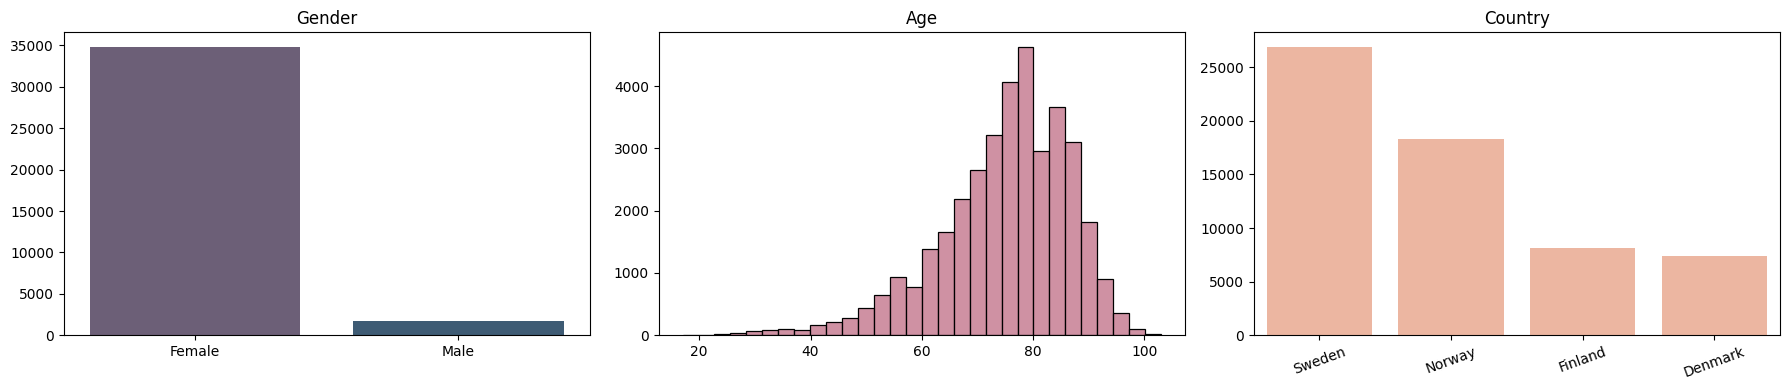

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure correct mapping and types
country_map = {58: 'Denmark', 205: 'Sweden', 160: 'Norway', 72: 'Finland'}
# invoiceCountryId is object, so map after converting to int where possible
def map_country(val):
    try:
        return country_map.get(int(val), val)
    except (ValueError, TypeError):
        return val

customers['Country'] = customers['invoiceCountryId'].apply(map_country).astype(str)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Gender plot
sns.countplot(
    data=customers,
    x='Gender',
    hue='Gender',
    palette=['#6C5B7B', '#355C7D'],
    ax=axes[0],
    order=['Female', 'Male'] if set(customers['Gender'].dropna()) == {'Female', 'Male'} else None,
    legend=False
)
axes[0].set(title='Gender', xlabel='', ylabel='')

# Age histogram
sns.histplot(
    customers['Age'].dropna().astype(float),
    bins=30,
    color='#C06C84',
    ax=axes[1]
)
axes[1].set(title='Age', xlabel='', ylabel='')

# Country plot
country_order = customers['Country'].value_counts().index
sns.countplot(
    x='Country',
    data=customers,
    order=country_order,
    color='#F8B195',
    ax=axes[2]
)
axes[2].set(title='Country', xlabel='', ylabel='')
axes[2].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

In [50]:
print(len(customers))

60702


In [51]:
print("Number of unique shopUserId:", customers['shopUserId'].nunique())


Number of unique shopUserId: 60702


In [52]:
customers.to_parquet('../data/processed/customers_clean.parquet', index=False)

In [53]:
customers.isna().sum()



shopUserId              0
invoiceFirstName        0
invoiceLastName         0
invoiceSSN              0
invoiceZip              0
invoiceCity             0
invoiceCountryId        0
invoiceEmail            0
_row                    0
Gender              24108
Age                 24108
Country                 0
dtype: int64